# Logistic Regression

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import sklearn
from collections import defaultdict
from tqdm.notebook import tqdm
from ipywidgets import interact
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Part 1 - 1D Toy example
Consider the case where random numbers are created by two different Gaussian distributions with identical variance. We also know the labels from which distribution each number was originating from. The generated data could, for example, represent how many days a student has learned for the ML exam and the target variable is if they have passed.

In [81]:
students_passed = np.random.normal(5,0.7,100)
students_passed[1:20]

array([5.45279861, 3.56179218, 5.9377502 , 5.10527752, 5.33248893,
       4.71159867, 4.23197935, 4.95195809, 4.71544966, 4.04453338,
       6.41788282, 4.7538092 , 6.03948962, 6.2846018 , 5.2679304 ,
       5.54657653, 5.32074533, 4.67363483, 5.20423151])

In [82]:
students_failed = np.random.normal(2,0.7,100)
students_failed[1:20]

array([1.06061275, 2.45010326, 3.35672428, 2.77066936, 1.28541395,
       1.78197233, 0.94441958, 2.09478794, 1.70510964, 1.54443184,
       2.963861  , 2.2227684 , 1.1354418 , 1.85511176, 2.11422383,
       0.90266272, 1.13517895, 3.03658006, 1.23309247])

To use this data for a logistic regression model, we combine the vectors $\text{students passed}$ and $\text{students failed}$ into a vector $X$ and create the corresponding labels $y$.

In [83]:
# label: failed
zeros = [0]*100
# label: passed
ones = [1]*100

X = np.concatenate((students_passed, students_failed))
y = np.concatenate((ones, zeros))

print(X[1:20])
print(y[1:20])

[5.45279861 3.56179218 5.9377502  5.10527752 5.33248893 4.71159867
 4.23197935 4.95195809 4.71544966 4.04453338 6.41788282 4.7538092
 6.03948962 6.2846018  5.2679304  5.54657653 5.32074533 4.67363483
 5.20423151]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


We plot both type of points in a scatter plot, where the points generated by the first distribution are plotted in blue have the label $y=0$, while the points of the second distribution are plotted in orange at $y=1$.

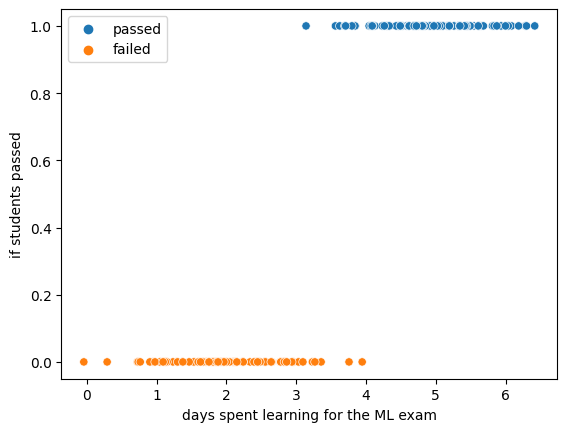

In [84]:
legend_map = {0: 'failed', 1: 'passed'}
ax = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map))
ax.set_xlabel('days spent learning for the ML exam')
ax.set_ylabel('if students passed')
plt.show()

Now we would like to determine, if an arbitrary previously unseen point belongs rather to distribution 1 or two distribution 2. For that, we want to employ logistic regression. Similar to linear regression, we first consider a model with a single independent variable and two parameters $\theta_0$ and $\theta_1$.

The probability, that $x$ belongs to either of the two classes is determined using the sigmoid function.

$$
  \sigma(x) = \frac{1}{1+e^{-(\theta_0 + \theta_1x)}}
$$


> Implement the sigmoid function

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

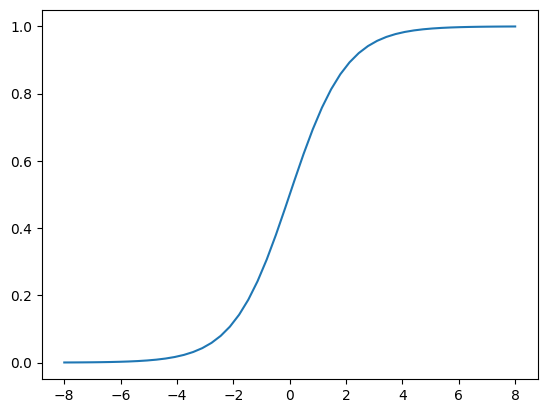

In [7]:
x = np.linspace(-8, 8)
plt.plot(x, sigmoid(x))

**Programming Assisgnment - Verifciation on Ilias**

> Implement the `predict` function. On **Ilias**, report the i=7 entry of y_pred below and check if your implementation is correct.

In [68]:
def predict(X, theta0, theta1):
    y_pred = sigmoid(theta0 + np.dot(X, theta1))
    return y_pred

In [86]:
theta0 = 1.0
theta1 = 1.0

y_pred = predict(X, theta0, theta1)
y_pred[0:20]

array([0.99844392, 0.99842638, 0.98966461, 0.99903049, 0.9977739 ,
       0.99822555, 0.99670352, 0.99468546, 0.997406  , 0.99671615,
       0.9935968 , 0.99939994, 0.99683934, 0.99912419, 0.99931445,
       0.99810744, 0.99856704, 0.99820463, 0.99657641, 0.99798321])

In [70]:
X[7]

5.367591971123823

**The value below is the answer for the Ilias Quiz "05A Supervised Learning: Classification"**

In [87]:
y_pred[7]

0.9946854560225327

### Visualize Decision Boundary
The decision boundary is given by the x such that: $-\theta_0-\theta_1 x=0$.

We can solve this equation for x: $x=-\frac{\theta_0}{\theta_1}$
Now let us plot the decision boundary and the logistic function

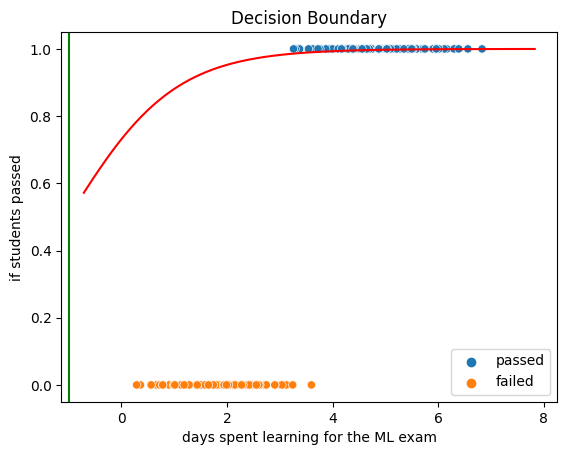

In [12]:
def plot_decision_boundary(X, theta0, theta1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.arange(X.min()-1, X.max()+1, 0.01).reshape(-1,1)
    y_pred = predict(x, theta0, theta1)
    ax.plot(x, y_pred, color="r")
    ax.axvline(-theta0/theta1, color="g")
    ax.set_title("Decision Boundary")
    
legend_map = {0: 'failed', 1: 'passed'}
ax = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map))
ax.set_xlabel('days spent learning for the ML exam')
ax.set_ylabel('if students passed')
plot_decision_boundary(X, theta0, theta1, ax)
plt.show()

### Cost function
The cross-entropy cost function $J(\boldsymbol\theta)$, where $\boldsymbol\theta=\left(\theta_0,\theta_1\right)$ is given by

$$
    J(\boldsymbol\theta) =
      - \frac{1}{n} \sum_{i=1}^n%
        \left[y_i\log h(\boldsymbol\theta,\mathbf{X_i})
            + (1-y_i)\log\left(
               1-h(\boldsymbol\theta,\mathbf{X_i})\right)\right]
$$

where $h(\boldsymbol\theta,\mathbf{X_i})=\sigma\left(\mathbf{X_i}^T\boldsymbol\theta\right)=\sigma\left(\theta_0+\theta_1 x\right)$ and $\sigma$ is the sigmoid function.

> Implement the cost function. Verify your code by running the next cell.

In [13]:
def cost_function(y, y_pred):
    n = len(y)
    return (-1. / n) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

If your code is correct, you should be able to run the following cell:

In [14]:
y_assert = np.array([1, 0, 0])
y_pred = np.array([0.98, 0.2, 0.6])

expected_cost = 0.38654566350196135
actual_cost = cost_function(y_assert, y_pred)

np.testing.assert_almost_equal(actual_cost, expected_cost, decimal=3)

### Gradients
For applying gradient descent, we define the gradient.

In [15]:
def gradient(X, y, theta0, theta1):
    y_pred = predict(X, theta0, theta1)
    diff = y_pred - y
    
    n = len(X)
    grad_theta0 = np.sum(diff) / n
    grad_theta1 = np.dot(diff, X.T) / n
    
    return grad_theta0, grad_theta1

### Gradient Descent
Now we are ready to determine the optimal values for the parameters $\theta_0$ and $\theta_1$ using the gradient descent algorithm.


$$
\mathbf{Repeat}\;\mathrm{(until}\;\mathrm{convergence)} \left\{\right.
  \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\\
      \boldsymbol\theta_{k+1} = \boldsymbol\theta_{k}-\alpha\frac{1}{n}\sum_{i=1}^n
          \left(h(\boldsymbol\theta_k,\mathbf{x}^{(i)})-y^{(i)}\right)\mathbf{x}^{(i)},
          \quad k = 0,\,1,\,2,\,3,\,\ldots,\mathtt{kmax}\\
    \left.\right\}\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$



> Implement the `fit` function

In [16]:
def fit(X, y, alpha, num_epochs, display_every=10):
    theta0 = 0.0
    theta1 = np.random.randn()
    
    hist = defaultdict(list)
    for i in tqdm(range(num_epochs)):
        # START YOUR CODE
        # calculate gradients
        grad_theta0, grad_theta1 = gradient(X, y, theta0, theta1)
        
        # update model parameters theta0 and theta1
        theta0 = theta0 - alpha * grad_theta0
        theta1 = theta1 - alpha * grad_theta1
        
        # calculate the current costs
        y_pred = predict(X, theta0, theta1)
        curr_cost = cost_function(y, y_pred)
        
        # END YOUR CODE
        
        hist["cost"].append(curr_cost)
        hist["theta0"].append(theta0)
        hist["theta1"].append(theta1)
        
        if i == 0 or (i+1) % display_every == 0:
            print("Epoch {} -  cost: {}".format(i+1, curr_cost))
        
    return theta0, theta1, hist

#### Plot validation curve
We implement a function that allows us to plot the validation curve.

In [17]:
def plot_validation_curve(costs, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_ylabel("Cost")
    ax.set_title("Validation Curve")
    ax.set_xlabel("Epochs")
    ax.plot(costs)

#### Run gradient descent algorithm
Let's run the gradient descent algorithm!

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1 -  cost: 0.614432811120066
Epoch 1000 -  cost: 0.1435575501986763
Epoch 2000 -  cost: 0.10368124318534865
Epoch 3000 -  cost: 0.08742989343356318
Epoch 4000 -  cost: 0.0782407029934835
Epoch 5000 -  cost: 0.07220086391424967
Epoch 6000 -  cost: 0.06786895759847272
Epoch 7000 -  cost: 0.06457944799851009
Epoch 8000 -  cost: 0.06197882699217438
Epoch 9000 -  cost: 0.059860351213985474
Epoch 10000 -  cost: 0.05809427893220785


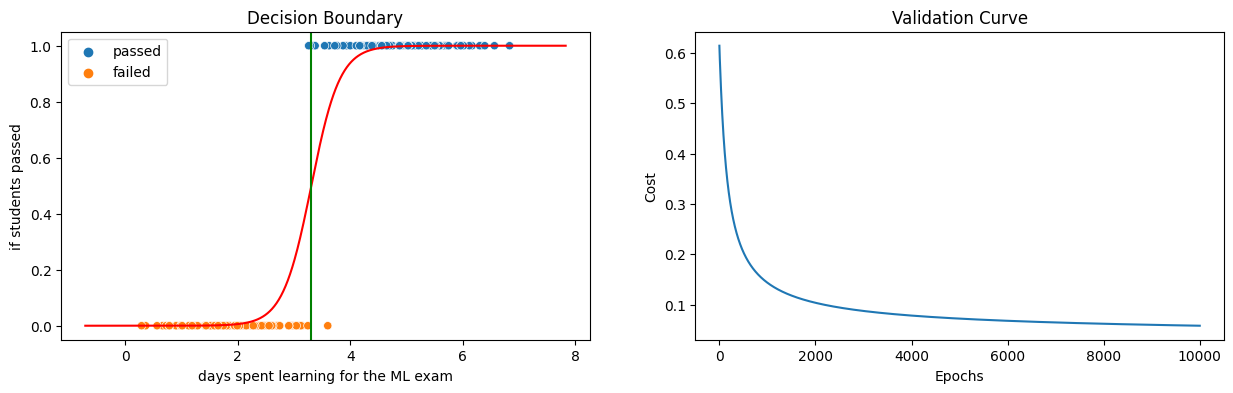

In [18]:
alpha = 0.1
num_epochs = 10000

theta0, theta1, hist = fit(X, y, alpha, num_epochs, display_every=1000)

fig, ax = plt.subplots(ncols=2, figsize=(15,4))

# scatter plot
legend_map = {0: 'failed', 1: 'passed'}
ax[0] = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map), ax=ax[0])
ax[0].set_xlabel('days spent learning for the ML exam')
ax[0].set_ylabel('if students passed')
plot_decision_boundary(X, theta0, theta1, ax[0])

# validation curve
plot_validation_curve(hist["cost"], ax=ax[1])

### Visualize Learning 
Let's visualize how the decision boundary changes over time.

In [19]:
@interact(epoch=(0, len(hist["theta0"]), 100))
def visualize_learning(epoch=100):
    legend_map = {0: 'failed', 1: 'passed'}
    ax = sns.scatterplot(X, y, hue=pd.Series(y).map(legend_map))
    ax.set_xlabel('days spent learning for the ML exam')
    ax.set_ylabel('if students passed')
    if epoch == 0:
        epoch += 1
    plot_decision_boundary(X, hist["theta0"][epoch-1], hist["theta1"][epoch-1], ax)
    plt.show()


interactive(children=(IntSlider(value=100, description='epoch', max=10000, step=100), Output()), _dom_classes=…

### Metrics
Let's calculate the accuracy

In [20]:
y_pred = predict(X, theta0, theta1)
y_pred[0:10]

array([0.99990852, 0.9999682 , 0.99988068, 0.90492571, 0.9999616 ,
       0.56135962, 0.99987816, 0.99969985, 0.98587406, 0.99946302])

We label a point as 1 if the predicted value is larger than 0.5

In [21]:
y_pred_class = y_pred > 0.5

In [22]:
y_pred_class

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [23]:
accuracy = accuracy_score(y, y_pred_class)

print("Accuracy: ", accuracy)

Accuracy:  0.985


## Part 2 - Multiple Logistic Regression - Toy example
In the second part, logistic regression is used in a 2D toy example. Here the data is loaded from a `.csv` file, but it was also generated artificially for illustration purposes. Here the data can, for example, correspond to
* feature 1: days spent learning for the ML exam
* feature 2: days spent working in the ML domain (prior experience)
* target variable: if students have passed the exam

In [24]:
df = pd.read_csv("classification_data.csv", header=None)
df.columns = ['days spent learning', 'prior experience', 'exam passed']
df.head()

,days spent learning,prior experience,exam passed
0,4.855064,9.639962,1
1,8.625440,0.058927,0
2,3.828192,0.723199,0
3,7.150955,3.899420,1
4,6.477900,8.198181,1


In [25]:
n = len(df)
X_2d = df.values[:, 0:2]
y_2d = df.values[:,2]

Split the data into training and test set.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_2d, y_2d, test_size=0.1)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (90, 2)
y_train: (90,)


### Predict function
The first step is to modify our `predict` function to handle multiple thetas.

In [27]:
def predict(X, bias, thetas):
    y_pred = sigmoid(bias + np.dot(X, thetas))
    return y_pred

### Gradient function
Let's modify the `gradient` function.

In [28]:
def gradient(X, y, bias, thetas):
    y_pred = predict(X, bias, thetas)
    diff = y_pred - y
    
    n = len(X)
    grad_bias = np.sum(diff) / n
    grad_thetas = np.dot(diff, X) / n
    
    return grad_bias, grad_thetas

### Gradient descent algorithm


In [29]:
def fit(X, y, alpha, num_epochs, display_every=100):
    bias = 0.0
    thetas = np.random.randn(*(1, X.shape[1])).reshape(-1)
        
    hist = defaultdict(list)
    for epoch in tqdm(range(1, num_epochs+1)):
        # calculate gradients
        grad_bias, grad_thetas = gradient(X, y, bias, thetas)
        
        # update model parameters
        bias = bias - alpha * grad_bias
        thetas = thetas - alpha * grad_thetas
        
        # calculate the current costs
        y_pred = predict(X, bias, thetas)
        curr_cost = cost_function(y, y_pred)
        
        hist["cost"].append(curr_cost)
        
        if epoch % display_every == 0:
            print("Epoch {} -  cost: {}".format(epoch, curr_cost))
        
    return bias, thetas, hist

### Apply Gradient Descent
> Apply the gradient descent algorithm. Use the learning rate 0.1. Plot the validation curve.

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1000 -  cost: 0.30228804274440874
Epoch 2000 -  cost: 0.26410568571025644
Epoch 3000 -  cost: 0.2481981439956785
Epoch 4000 -  cost: 0.23932120683714583
Epoch 5000 -  cost: 0.23365768727159947
Epoch 6000 -  cost: 0.22975454746904453
Epoch 7000 -  cost: 0.22692617748397637
Epoch 8000 -  cost: 0.2248030911403237
Epoch 9000 -  cost: 0.22316725133193172
Epoch 10000 -  cost: 0.2218812225853835


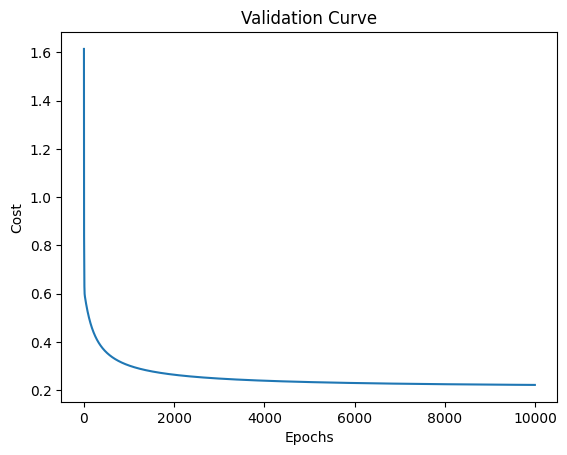

In [30]:
alpha = 0.1
num_epochs = 10000

bias_2d, thetas_2d, hist = fit(X_train, y_train, alpha, num_epochs, display_every=1000)

plot_validation_curve(hist["cost"])

### Plot decision boundary

decision boundary: -12.133 + 1.324 * x1 + 1.127 * x2 = 0


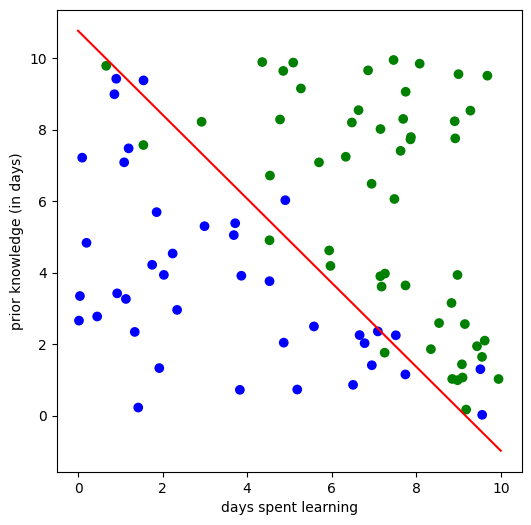

In [31]:
print("decision boundary: %.3f + %.3f * x1 + %.3f * x2 = 0"
      % (bias_2d, thetas_2d[0], thetas_2d[1]))

x1 = np.array(X_train[:,0].T)
x2 = np.array(X_train[:,1].T)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlabel('days spent learning')
ax.set_ylabel('prior knowledge (in days)')
color = ['blue' if l == 0 else 'green' for l in y_train]
scat = ax.scatter(x1, x2, color=color)

# inline function for decision boundary (unless vertical)
y_ = lambda x: ((-1)*(bias_2d + thetas_2d[0]*x) / thetas_2d[1])

def plot_line(y, data_pts):
    x_vals = [i for i in
              range(int(min(data_pts)-1),
                    int(max(data_pts))+2)]
    y_vals = [y(x) for x in x_vals]
    plt.plot(x_vals,y_vals, 'r')

plot_line(y_, x1)
plt.show()

### Evaluation
How should we evaluate our result? Of course this is highly dependent on both our original business problem and the data at hand. Questions such as
* Does the evaluation result need to be explainable to management, without using formulas and technical terms?
* Do we have a high class imbalance?
* Are False Positives and False Negatives equally bad? Does one of the two incur a high cost for our business and needs to be avoided?
* How do we rate the confidence? Do we want to penalise a classifier when it classifies a sample wrongly but is very sure of this result?

We will look at the metrics Accuracy and F1-Score.

> Predict the data on the test set.

In [48]:
y_pred = predict(X_test, bias_2d, thetas_2d)
y_pred = y_pred > 0.5

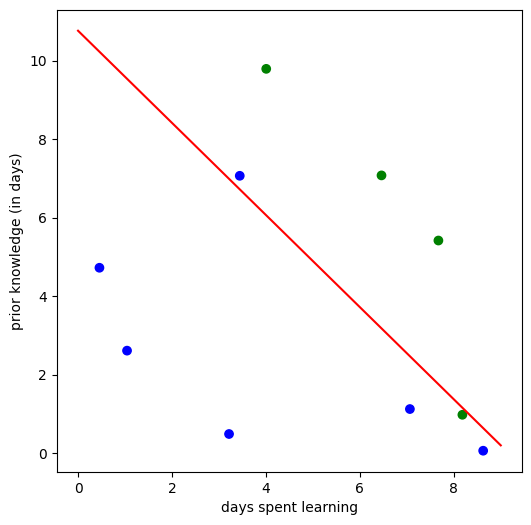

In [33]:
x1 = np.array(X_test[:,0].T)
x2 = np.array(X_test[:,1].T)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlabel('days spent learning')
ax.set_ylabel('prior knowledge (in days)')
color = ['blue' if l == 0 else 'green' for l in y_test]
scat = ax.scatter(x1, x2, color=color)

# inline function for decision boundary (unless vertical)
y_ = lambda x: ((-1)*(bias_2d + thetas_2d[0]*x) / thetas_2d[1])

def plot_line(y, data_pts):
    x_vals = [i for i in
              range(int(min(data_pts)-1),
                    int(max(data_pts))+2)]
    y_vals = [y(x) for x in x_vals]
    plt.plot(x_vals,y_vals, 'r')

plot_line(y_, x1)
plt.show()

#### Confusion Matrix
First we compute and plot the confusion matrix using the utility methods `compute_confusion_matrix` and `plot_confusion_matrix`.

In [34]:
def compute_confusion_matrix(true, pred):
    # number of classes
    K = len(np.unique(true))
    c_mat = np.zeros((K, K))
    
    for i in range(len(true)):
        c_mat[int(true[i])][int(pred[i])] += 1
        
    return c_mat

def plot_confusion_matrix(cm):
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Actual True', 'Actual False'],
                yticklabels=['Predicted True', 'Predicted False'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

In [35]:
y_test

array([0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])

In [44]:
y_pred

[False, False, False, False, False, False, False, False, False, False]

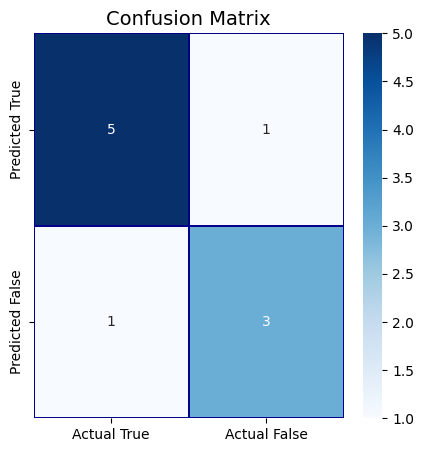

In [49]:
cm = compute_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

> Finally calculate and print the accuracy and the f1 score.

In [50]:
def extract_scores(confusion_matrix):
    """
    Extracts the tp, tn, fp, fn from the
    confusion matrix.
    """
    # true positive
    tp = confusion_matrix[0][0]
    # true negative
    tn = confusion_matrix[1][1]
    # false positive
    fp = confusion_matrix[0][1]
    # false negative
    fn = confusion_matrix[1][0]
    
    return tp, tn, fp, fn

def accuracy_score(confusion_matrix):
    """
    Computes the accuracy from a confusion matrix.
    """
    tp, tn, fp, fn = extract_scores(confusion_matrix)
    acc = (tp + tn)/np.sum(confusion_matrix)
    
    return acc

def f1_score(confusion_matrix):
    """
    Computes the f1 score from a confusion matrix.
    """
    tp, tn, fp, fn = extract_scores(confusion_matrix)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return f1

In [51]:
accuracy = accuracy_score(cm)
f1 = f1_score(cm)

In [52]:
accuracy

0.8

In [47]:
f1

0.7499999999999999

## Programming Assignment
> Solve the following Programming assignment and check your solution in the Illias Quiz **05A Supervised Learning: Classification - Notebook Verification**.

In the previous examples you implemented Logistic Regression from scratch. Now you are going to repeat the calulcations using scikit-learn's implementation of Logistic Regression. Use the data of the Multiple Logistic Regression example also using the identical train/test splits.

Train the Logistic Regression, what is the score on the test set? 

In [56]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8

What is the standard metric of the score function of scikitlearn's implementation of LogisticRegression?

In [ ]:
"Mean accuracy of self.predict(X) w.r.t. y."

In [57]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Check your answers in the Ilias Quiz.